In [2]:
from glob import glob
import json
import os

import numpy as np
import pandas as pd

from plotnine import *

from dataclasses import dataclass
from collections import defaultdict
from typing import Dict, List, Set

# TODO

- combine pipeline into a single location
- put everything in github
- run on past batch of sequencing

**Downstream analysis**
- compare to SNV data in COVIDCG and see which lineages or if novel SNVs
- merge tables with ASVs from multiple batches
- plot abundances over time and space

# Define amplicons

In [349]:
# primer locations:
s1s2_F1 = [22985, 23004]
s1s2_F2 =[23202, 23221]
s1s2_R2 = [23741, 23763]
s1s2_R1 = [23892, 23913]
ntd_F1 = [21663, 21686]
ntd_F2 = [21707, 21729]
ntd_R2 = [22221, 22241]
ntd_R1 = [22322, 22341]
rbd_F1 = [22732, 22758]
rbd_F2 = [22773,22794]
rbd_R2 = [23300, 23322]
rbd_R1 = [23382,23403]

rbd_range = [22795, 23299]
s1s2_range = [23222, 23740]
ntd_range = [21730, 22220]

# Load and process the GISAID mutation table from COVID-CG

In [3]:
var_aa_df = pd.read_json("/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_111521_aa.json")
var_aa_df.head()

,name,count,fraction,mutation_id,gene,pos,ref,alt,mutation_name
0,A,1915,0.908444,61267,ORF8,84,L,S,ORF8:L84S
1,A.1,2949,0.946709,27261,ORF1ab,5828,P,L,ORF1ab:P5828L
2,A.1,3100,0.995185,61267,ORF8,84,L,S,ORF8:L84S
3,A.11,13,1.000000,61267,ORF8,84,L,S,ORF8:L84S
4,A.12,6,1.000000,61267,ORF8,84,L,S,ORF8:L84S


In [3]:
covid_cg_snvs1 = "/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_1perc_110821.json"
var1_df = pd.read_json(covid_cg_snvs1)
var1_df = var1_df.rename(columns={'pos':'position', 'name':'variant'})

In [321]:
# check primer regions for mutations in GISAID that could bias amplification
# filter variants table to see whether there are mutations in the primer regions
start = s1s2_F1[0]
stop = s1s2_F1[1]
var1_df[(var1_df.position >= start) &
        (var1_df.position <= stop) &
        (var1_df.fraction > 0.9)
       ].sort_values('variant')

# Note that rbd_R1 primer is degenerate for A23403G or be degenerate (S:D614G, in almost everything at this point; in all delta)
# note that s1s2_F1 primer is degenerate for C22995A (S:T478K, in all delta)

# update ntd_R2 primer to be degenerate: C22227T (S:A222)

,variant,count,fraction,snv_id,position,ref,alt,snv_name
309,A.2.5.3,74,0.986667,34468,22992,G,A,G22992A
603,A.30,4,1.000000,34480,22995,C,G,C22995G
867,AB.1,116,1.000000,34468,22992,G,A,G22992A
34985,AE.6,24,1.000000,34452,22987,C,T,C22987T
1859,AY.1,2128,0.964642,34479,22995,C,A,C22995A
...,...,...,...,...,...,...,...,...
28972,B.1.630,117,0.975000,34480,22995,C,G,C22995G
29098,B.1.633,13,0.928571,34479,22995,C,A,C22995A
29189,B.1.635,52,0.962963,34468,22992,G,A,G22992A
30453,C.1.1,13,1.000000,34468,22992,G,A,G22992A


In [332]:
aggregated_covidcg_CA = pd.read_csv('/Users/rosekantor/data/wbe_scv/variant_info/aggregate_sequences_covidcg_111121.csv')

In [348]:
aggregated_covidcg_CA.sort_values('count', ascending=False)

(7376, 4)

In [284]:
# filter at 90% and make sets to test
# notes
# insertion snv_name looks like '-29799A'
# deletion snv_name looks like 'GTTATG515-'
# but there are no insertions or deletions at 90% threshold

var90_df = var1_df[(var1_df.fraction > 0.9) &
                   (var1_df.position >=22794) &
                   (var1_df.position <= 23299)][['variant', 'snv_name']]
var90_df = var90_df.groupby('variant').agg(lambda x: x.tolist()).reset_index()

variant_dict = {}
for r in var90_df.itertuples():
    variant_dict[r.variant] = set(r.snv_name)

## Define lineages by presence and absence of mutations within the position range of the amplicon

In [350]:
# Load data
covid_cg_snvs = "/Users/rosekantor/data/wbe_scv/variant_info/consensus_mutations_covidcg_1perc_110821.json" # should use 90%
data = open(covid_cg_snvs, "r").read()
data = json.loads(data)

# Get list of SNVs associated with each GISAID variant within each range
variant_snvs_ntd: Dict[str, Set[str]] = defaultdict(set)
variant_snvs_rbd: Dict[str, Set[str]] = defaultdict(set)
variant_snvs_s1s2: Dict[str, Set[str]] = defaultdict(set)

for variant in data:
    if ntd_range[1] >= variant['pos'] >= ntd_range[0]: 
        variant_snvs_ntd[variant["name"]].add(variant["snv_name"])
    if rbd_range[1] >= variant['pos'] >= rbd_range[0]: 
        variant_snvs_rbd[variant["name"]].add(variant["snv_name"])
    if s1s2_range[1] >= variant['pos'] >= s1s2_range[0]: 
        variant_snvs_s1s2[variant["name"]].add(variant["snv_name"])

In [353]:
variant_snvs_rbd['B.1.617.2']
variant_snvs_s1s2['B.1.617.2']
variant_snvs_ntd['B.1.617.2']

{'AGTTCA22029-', 'C21846T', 'G21987A'}

# Load sample data

In [361]:
asvs_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110521/results/nextclade_out/S1S2_nextclade.csv', sep=';')
asvs_df = asvs_df.replace(np.nan, '')
asvs_df[['seqName', 'clade', 'substitutions', 'deletions', 'insertions',
       'frameShifts', 'aaSubstitutions', 'aaDeletions', 'missing', 'nonACGTNs',
       'pcrPrimerChanges', 'alignmentScore', 'alignmentStart', 'alignmentEnd']].head()

,seqName,clade,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions,missing,nonACGTNs,pcrPrimerChanges,alignmentScore,alignmentStart,alignmentEnd
0,Seq1,20B,"A23403G,C23604G",23412-23413,,,,,,,,1535,23221,23740
1,Seq2,20B,"A23403G,C23604G",,,,"S:D614G,S:P681R",,,,,1549,23221,23740
2,Seq3,20A,"A23403G,G23587T,C23604G",,,,"S:D614G,S:Q675H,S:P681R",,,,,1545,23221,23740
3,Seq4,19A,,,,,,,,,,1557,23221,23740
4,Seq5,20B,"C23320T,A23403G,C23604G",,,,"S:D614G,S:P681R",,,,,1545,23221,23740


In [362]:
asvs_df

,seqName,clade,qc.overallScore,qc.overallStatus,totalSubstitutions,totalDeletions,totalInsertions,totalFrameShifts,totalAminoacidSubstitutions,totalAminoacidDeletions,...,qc.frameShifts.totalFrameShifts,qc.frameShifts.frameShiftsIgnored,qc.frameShifts.totalFrameShiftsIgnored,qc.frameShifts.score,qc.frameShifts.status,qc.stopCodons.stopCodons,qc.stopCodons.totalStopCodons,qc.stopCodons.score,qc.stopCodons.status,errors
0,Seq1,20B,0.0000,good,2,2,0,0,0,0,...,0,,0,0.0,good,,0,0.0,good,
1,Seq2,20B,0.0000,good,2,0,0,0,2,0,...,0,,0,0.0,good,,0,0.0,good,
2,Seq3,20A,0.0000,good,3,0,0,0,3,0,...,0,,0,0.0,good,,0,0.0,good,
3,Seq4,19A,0.0000,good,0,0,0,0,0,0,...,0,,0,0.0,good,,0,0.0,good,
4,Seq5,20B,0.0000,good,3,0,0,0,2,0,...,0,,0,0.0,good,,0,0.0,good,
5,Seq6,20B,0.0000,good,3,0,0,0,3,0,...,0,,0,0.0,good,,0,0.0,good,
6,Seq7,20B,0.0000,good,8,0,1,0,0,0,...,0,,0,0.0,good,,0,0.0,good,
7,Seq8,20B,0.0000,good,3,0,0,0,2,0,...,0,,0,0.0,good,,0,0.0,good,
8,Seq9,20B,56.2500,mediocre,2,17,0,1,1,5,...,1,,0,75.0,mediocre,,0,0.0,good,
9,Seq10,19B,56.2500,mediocre,1,41,0,1,1,13,...,1,,0,75.0,mediocre,,0,0.0,good,


In [358]:
abund_df = pd.read_csv('/Users/rosekantor/data/wbe_scv/qb3_sgene_110521/results/dada2_out/S1S2_dada2_out.csv')

# generate seqnames to match the names in the fasta used in NextStrain
seq_count = len(abund_df.columns)
seq_names = ['Seq'+str(x) for x in range(seq_count+1)][1:]

abund_df.columns = seq_names
abund_df = abund_df.transpose() # flip table rows to columns
# drop samples with fewer than 1000 reads total
abund_df = abund_df.drop(abund_df.columns[abund_df.sum(axis=0) < 1000], axis=1)

# if a seq has < 10 reads in a sample, change readcount to zero to avoid low-abundance artefacts
abund_df = abund_df.mask(abund_df < 10, 0)

# normalize to get relative abundance within samples
abund_df = abund_df.div(abund_df.sum(axis=0), axis=1)

# if a seq is < 1%, mask so we aren't considering rare variants since these will add noise
abund_df = abund_df.mask(abund_df < 0.01, 0)

# drop rows that sum to zero after all this masking
abund_df = abund_df.drop(abund_df.index[abund_df.sum(axis=1) == 0], axis=0)

# round proportions so easier to look at and convert to percentages
abund_df = abund_df.round(3) * 100

# make seqName a column and put at far left of table
abund_df.insert(0, 'seqName', abund_df.index)

# order the sequences in the order they appear in the table, so they will plot nicely
abund_df.seqName = pd.Categorical(abund_df.seqName, ordered=True, categories=abund_df.seqName)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


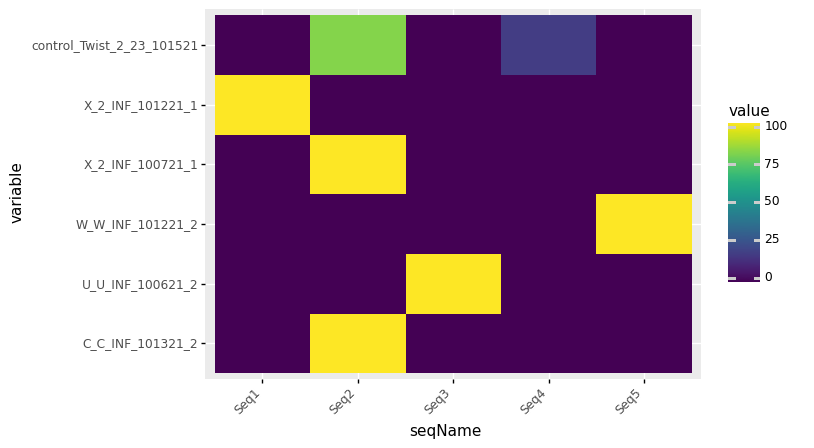

<ggplot: (373705322)>

In [359]:
(ggplot(abund_df.melt(id_vars='seqName'), aes(x='seqName', y='variable', fill='value'))+
geom_tile()+
theme(axis_text_x=element_text(angle=45, hjust=1)))

## Merge with sample information

In [227]:
samples_df = pd.read_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/full_wastewater_dataset_newformat_102121.csv')

In [228]:
# make informative sample names
sample_names = abund_df.columns[1:]
names_df = samples_df[samples_df.Sample.isin(sample_names)][['Sample', 'county', 'site_full_name', 'date_sampling']]
names_df['sample_name'] = names_df[['county', 'site_full_name', 'date_sampling']].agg('_'.join, axis=1)

In [229]:
# merge with transposed abundance data, drop extra columns and transpose back
abund_named_df = names_df[['Sample', 'sample_name']].merge(abund_df.transpose(), how='outer', left_on='Sample', right_index=True)

# drop the row that resulted from the 'seqName' column
abund_named_df = abund_named_df[abund_named_df.Sample != 'seqName']
# make sure controls keep their names (since they don't have county or site names)
abund_named_df.loc[abund_named_df.Sample.str.contains('control'), 'sample_name'] = abund_named_df.Sample

# prepare to transpose
abund_named_df.index = abund_named_df.sample_name
abund_named_df = abund_named_df.drop(columns=['Sample', 'sample_name'])
abund_named_df = abund_named_df.transpose()

# recreate the seqName column
abund_named_df.insert(0, 'seqName', abund_named_df.index)
# order the sequences in the order they appear in the table, so they will plot nicely
abund_named_df.seqName = pd.Categorical(abund_df.seqName, ordered=True, categories=abund_df.seqName)

In [234]:
abund_named_melt_df = abund_named_df.melt(id_vars='seqName')
abund_named_melt_df.value = pd.to_numeric(abund_named_melt_df.value)

/opt/homebrew/Caskroom/miniforge/base/lib/python3.9/site-packages/plotnine/utils.py:1246: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if pdtypes.is_categorical(arr):


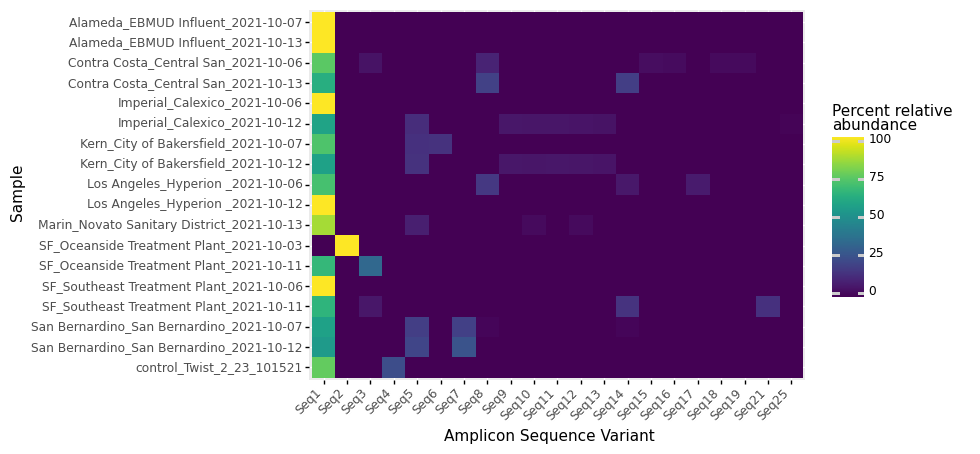

<ggplot: (356410956)>

In [242]:
(ggplot(abund_named_melt_df, aes(x='seqName', y='sample_name', fill='value'))+
geom_tile()+
coord_trans(y='reverse')+ # reverse the y axis
labs(fill='Percent relative\nabundance\n')+
xlab('Amplicon Sequence Variant')+
ylab('Sample')+
theme(axis_text_x=element_text(angle=45, hjust=1)))

## Merge abundance with NextStrain info

In [256]:
asvs_short_df = asvs_df[['seqName', 'substitutions', 'deletions', 'insertions', 'frameShifts', 'aaSubstitutions', 'aaDeletions']]
asvs_short_df = asvs_short_df[asvs_short_df.seqName.isin(abund_df.index)]
asvs_short_df[asvs_short_df.aaSubstitutions.str.contains('K417N')]

,seqName,substitutions,deletions,insertions,frameShifts,aaSubstitutions,aaDeletions
7,Seq8,"G22813T,T22917G,C22995A",,,,"S:K417N,S:L452R,S:T478K",
16,Seq17,"G22813T,T22917G,T22951C,C22995A",,,,"S:K417N,S:L452R,S:T478K",
20,Seq21,"G22813T,T22917G,C22995A,G23259T",,,,"S:K417N,S:L452R,S:T478K,S:G566V",


In [258]:
asvs_short_df

# assign lineages based on complete intersection of mutations

In [286]:
lineage_results = {}
for r in asvs_short_df.itertuples():
    lineages = []
    snvs = set(r.substitutions.split(','))

    for variant in variant_dict:
        variant_snvs = variant_snvs_dict[variant]
        
        if snvs == variant_snvs:
            lineages.append(variant)
        lineage_results[r.seqName] = lineages

In [287]:
lineage_results

{'Seq1': ['AY.3', 'B.1.617.2'],
 'Seq2': [],
 'Seq3': [],
 'Seq4': [],
 'Seq5': ['AY.3.1'],
 'Seq6': [],
 'Seq7': [],
 'Seq8': ['AY.1', 'AY.2'],
 'Seq9': [],
 'Seq10': [],
 'Seq11': [],
 'Seq12': [],
 'Seq13': [],
 'Seq14': [],
 'Seq15': [],
 'Seq16': [],
 'Seq17': [],
 'Seq18': [],
 'Seq19': [],
 'Seq21': [],
 'Seq25': []}